In [1]:
%matplotlib inline

In [2]:
!pip install torchmetrics

Translation with a Sequence to Sequence Network
*************************************************************

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <http://arxiv.org/abs/1409.3215>`__, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

To improve upon this model we'll use an `attention
mechanism <https://arxiv.org/abs/1409.0473>`__, which lets the decoder
learn to focus over a specific range of the input sequence.

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <http://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <http://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`__

You will also find the previous tutorials on
:doc:`/intermediate/char_rnn_classification_tutorial`
and :doc:`/intermediate/char_rnn_generation_tutorial`
helpful as those concepts are very similar to the Encoder and Decoder
models, respectively.

And for more, read the papers that introduced these topics:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <http://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <http://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`__


**Requirements**



Loading data files
==================

The data for this project is a set of many thousands of English to
French translation pairs.

`This question on Open Data Stack
Exchange <http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
pointed me to the open translation site http://tatoeba.org/ which has
downloads available at http://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: http://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

::

    I am cold.    J'ai froid.

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.



In [3]:
!wget http://www.manythings.org/anki/fra-eng.zip
!unzip -o fra-eng.zip
!mkdir data
!mv fra.txt data/eng-fra.txt

--2024-04-02 15:53:31--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7943074 (7.6M) [application/zip]
Saving to: ‘fra-eng.zip.5’

fra-eng.zip.5       100%[===================>]   7.57M  5.12MB/s    in 1.5s    

2024-04-02 15:53:33 (5.12 MB/s) - ‘fra-eng.zip.5’ saved [7943074/7943074]

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 
mkdir: cannot create directory ‘data’: File exists


In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [6]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [7]:
MAX_LENGTH = 15

eng_prefixes = (
    "i am", "i m",
    "he is", "he s",
    "she is", "she s",
    "you are", "you re",
    "we are", "we re",
    "they are", "they re"
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [8]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
#print(random.choice(pairs))

Reading lines...
Read 232736 sentence pairs
Trimmed to 22907 sentence pairs
Counting words...
Counted words:
fra 7019
eng 4638


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = [i[0] for i in pairs]
y = [i[1] for i in pairs]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [12]:
train_pairs = list(zip(X_train,y_train))
test_pairs = list(zip(X_test,y_test))

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <http://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.






In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)


    def forward(self, input, hidden, cell):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded

        # output, (hn, cn) = lstm(input, (h0, c0))
        output, (hidden, cell) = self.lstm(output, (hidden, cell))

        return output, (hidden, cell)

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

    def initCells(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class EncoderLSTMBi(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderLSTMBi, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, bidirectional=True)


    def forward(self, input, hidden, cell):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded # [input_size, batch_size, 2*hidden_size]

        # output, (hn, cn) = lstm(input, (h0, c0))
        output, (hidden, cell) = self.lstm(output, (hidden, cell))

        # output will contain a concatenation of the forward and reverse hidden states at each time step in the sequence.
        return output, (hidden, cell)

    def initHidden(self):
        return torch.zeros(2, 1, self.hidden_size, device=device)

    def initCells(self):
        return torch.zeros(2, 1, self.hidden_size, device=device)


The Decoder (Your assignment)
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




Simple Decoder
^^^^^^^^^^^^^^

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).


In [14]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):

        # Your code here #
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)

        self.lstm = nn.LSTM(hidden_size, hidden_size)

        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):

        # Your code here #
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)

        # output, (hn, cn) = lstm(input, (h0, c0))
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        output = self.softmax(self.out(output[0]))

        return output, (hidden, cell)

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

    def initCells(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class DecoderLSTMBi(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderLSTMBi, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, 2*hidden_size)
        self.gru = nn.GRU(2*hidden_size, 2*hidden_size)
        self.out = nn.Linear(2*hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):

        # Your code here #
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(2, 1, self.hidden_size, device=device)

    def initCells(self):
        return torch.zeros(2, 1, self.hidden_size, device=device)

class DecoderAttn(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(DecoderAttn, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)

        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_hiddens):

        embedded = self.embedding(input).view(1, 1, -1) # [1, batch_size, hidden_size]
        # embedded = self.dropout(embedded) # [1, batch_size, hidden_size]

        attn = torch.mm(hidden[0], torch.transpose(encoder_hiddens, 0, 1)) # [batch_size, max_length]
        attndis = F.softmax(attn, dim=1) # [batch_size, max_length]
        attout = torch.mm(attndis, encoder_hiddens) # [batch_size, hidden_size]
        attout = attout.unsqueeze(0) # [1, batch_size, hidden_size]

        output = torch.cat((embedded[0], attout[0]), 1) # [batch_size, 2*hidden_size]
        output = self.attn_combine(output).unsqueeze(0) # [1, batch_size, hidden_size]

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attndis

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

    def initCells(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [15]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [16]:
teacher_forcing_ratio = 0.5

def train1(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        # original
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)

        encoder_outputs[ei] = encoder_output[0, 0]


    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # original
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)


            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            # original
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [17]:
teacher_forcing_ratio = 0.5

def train2(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    # LSTM
    encoder_cell = encoder.initCells()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        # LSTM
        encoder_output, (encoder_hidden, encoder_cell)  = encoder(input_tensor[ei], encoder_hidden, encoder_cell)

        encoder_outputs[ei] = encoder_output[0, 0]


    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    # LSTM
    decoder_cell = encoder_cell

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # LSTM
            decoder_output, (decoder_hidden, decoder_cell) = decoder(decoder_input, decoder_hidden, decoder_cell)


            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            # LSTM
            decoder_output, (decoder_hidden, decoder_cell) = decoder(decoder_input, decoder_hidden, decoder_cell)

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [18]:
teacher_forcing_ratio = 0.5

def train3(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    # LSTM
    encoder_cell = encoder.initCells()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # Bi-LSTM
    encoder_outputs = torch.zeros(max_length, 2*encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        # LSTM
        encoder_output, (encoder_hidden, encoder_cell)  = encoder(input_tensor[ei], encoder_hidden, encoder_cell)

        encoder_outputs[ei] = encoder_output[0, 0]


    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden # must be an easier way to reshape to 2x hidden?
    # Bi-LSTM
    decoder_hidden = torch.reshape(decoder_hidden, (1,1,2*decoder_hidden.shape[2]))


    # LSTM
    decoder_cell = encoder_cell

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # original decoder used
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)


            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            # original decoder used
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [19]:
teacher_forcing_ratio = 0.5

def train4(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_hiddens = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        # original
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)

        # encoder_outputs[ei] = encoder_output[0, 0]
        encoder_hiddens[ei] = encoder_hidden[0, 0]


    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # original
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_hiddens)


            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            # original
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_hiddens)

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [20]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [21]:
import matplotlib.pyplot as plt

def trainIters(encoder, decoder, epochs, print_every=1000, plot_every=100, learning_rate=0.01, train=train1):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    criterion = nn.NLLLoss()

    iter = 1
    n_iters = len(train_pairs) * epochs

    for epoch in range(epochs):
        print("Epoch: %d/%d" % (epoch, epochs))
        for training_pair in train_pairs:
            training_pair = tensorsFromPair(training_pair)

            input_tensor = training_pair[0]
            target_tensor = training_pair[1]

            loss = train(input_tensor, target_tensor, encoder,
                        decoder, encoder_optimizer, decoder_optimizer, criterion)

            print_loss_total += loss
            plot_loss_total += loss

            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                            iter, iter / n_iters * 100, print_loss_avg))
            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

            iter +=1

          # Plot training Curves
    plt.figure(figsize=(12,16))
    plt.plot(plot_losses)
    plt.ylim((0,max(plot_losses)))
    plt.xlabel('Iterations')
    plt.ylabel('Training Loss')
    return plot_losses





Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [22]:
def evaluate1(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

def evaluate2(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        # lstm
        encoder_cell = encoder.initCells()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            # lstm
            encoder_output, (encoder_hidden, encoder_cell) = encoder(input_tensor[ei], encoder_hidden, encoder_cell)

            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden


        decoded_words = []

        # LSTM
        decoder_cell = encoder_cell

        for di in range(max_length):
            # lstm
            decoder_output, (decoder_hidden, decoder_cell) = decoder(decoder_input, decoder_hidden, decoder_cell)

            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

def evaluate3(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        # lstm
        encoder_cell = encoder.initCells()

        # Bi-LSTM
        encoder_outputs = torch.zeros(max_length, 2*encoder.hidden_size, device=device)


        for ei in range(input_length):
            encoder_output, (encoder_hidden, encoder_cell) = encoder(input_tensor[ei], encoder_hidden, encoder_cell)

            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoder_hidden = torch.reshape(decoder_hidden, (1,1,2*decoder_hidden.shape[2]))

        decoded_words = []


        for di in range(max_length):
            # lstm
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

def evaluate4(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()


        encoder_hiddens = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_hiddens[ei] = encoder_hidden[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_hiddens)

            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        # return decoded_words

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [25]:
def evaluateRandomly(encoder, decoder, evaluate, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [26]:
from torchmetrics.text.rouge import ROUGEScore
from tqdm import tqdm
import numpy as np

rouge = ROUGEScore()

def test(encoder, decoder, testing_pairs, evaluate):
    input = []
    gt = []
    predict = []
    metric_score = {
        "rouge1_fmeasure":[],
        "rouge1_precision":[],
        "rouge1_recall":[],
        "rouge2_fmeasure":[],
        "rouge2_precision":[],
        "rouge2_recall":[]
    }
    from tqdm import tqdm
    for i in tqdm(range(len(testing_pairs))):
        pair = testing_pairs[i]
        output_words = evaluate(encoder, decoder, pair[0])
        # output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)

        input.append(pair[0])
        gt.append(pair[1])
        predict.append(output_sentence)

        try:
            rs = rouge(output_sentence, pair[1])
        except:
            continue
        metric_score["rouge1_fmeasure"].append(rs['rouge1_fmeasure'])
        metric_score["rouge1_precision"].append(rs['rouge1_precision'])
        metric_score["rouge1_recall"].append(rs['rouge1_recall'])
        metric_score["rouge2_fmeasure"].append(rs['rouge2_fmeasure'])
        metric_score["rouge2_precision"].append(rs['rouge2_precision'])
        metric_score["rouge2_recall"].append(rs['rouge2_recall'])

    metric_score["rouge1_fmeasure"] = np.array(metric_score["rouge1_fmeasure"]).mean()
    metric_score["rouge1_precision"] = np.array(metric_score["rouge1_precision"]).mean()
    metric_score["rouge1_recall"] = np.array(metric_score["rouge1_recall"]).mean()
    metric_score["rouge2_fmeasure"] = np.array(metric_score["rouge2_fmeasure"]).mean()
    metric_score["rouge2_precision"] = np.array(metric_score["rouge2_precision"]).mean()
    metric_score["rouge2_recall"] = np.array(metric_score["rouge2_recall"]).mean()

    print("=== Evaluation score - Rouge score ===")
    print("Rouge1 fmeasure:\t",metric_score["rouge1_fmeasure"])
    print("Rouge1 precision:\t",metric_score["rouge1_precision"])
    print("Rouge1 recall:  \t",metric_score["rouge1_recall"])
    print("Rouge2 fmeasure:\t",metric_score["rouge2_fmeasure"])
    print("Rouge2 precision:\t",metric_score["rouge2_precision"])
    print("Rouge2 recall:  \t",metric_score["rouge2_recall"])
    print("=====================================")
    return input,gt,predict,metric_score


Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




Epoch: 0/2
1m 5s (- 7m 56s) (5000 12%) 3.2602
2m 11s (- 6m 50s) (10000 24%) 2.6613
3m 17s (- 5m 46s) (15000 36%) 2.3381
4m 24s (- 4m 40s) (20000 48%) 2.1465
Epoch: 1/2
5m 31s (- 3m 35s) (25000 60%) 1.9510
6m 37s (- 2m 28s) (30000 72%) 1.7527
7m 43s (- 1m 22s) (35000 84%) 1.5906
8m 51s (- 0m 16s) (40000 97%) 1.4918
> il a dormi dans la voiture .
= he slept in the car .
< he s in the car . <EOS>

> il veut toujours venir .
= he still wants to come .
< he is always complaining to <EOS>

> je me rejouis que tu n etais pas ici .
= i m glad you weren t here .
< i m glad you weren t here . <EOS>

> je ne suis pas du tout interesse par la physique .
= i m not at all interested in physics .
< i m not at at all . . <EOS>

> nous sommes conscients des defis .
= we re aware of the challenges .
< we re aware of the risks . <EOS>

> je ne suis pas toujours a la maison le dimanche .
= i m not always home on sundays .
< i m always on on sundays on sundays . <EOS>

> tu raisonnes comme un enfant de tro

100%|██████████| 20616/20616 [02:25<00:00, 141.99it/s]


=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.6879349
Rouge1 precision:	 0.6492651
Rouge1 recall:  	 0.7407911
Rouge2 fmeasure:	 0.5145636
Rouge2 precision:	 0.4768595
Rouge2 recall:  	 0.5688729


100%|██████████| 2291/2291 [00:16<00:00, 137.20it/s]


=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.62394214
Rouge1 precision:	 0.5904058
Rouge1 recall:  	 0.67221373
Rouge2 fmeasure:	 0.43355218
Rouge2 precision:	 0.40353066
Rouge2 recall:  	 0.47851956


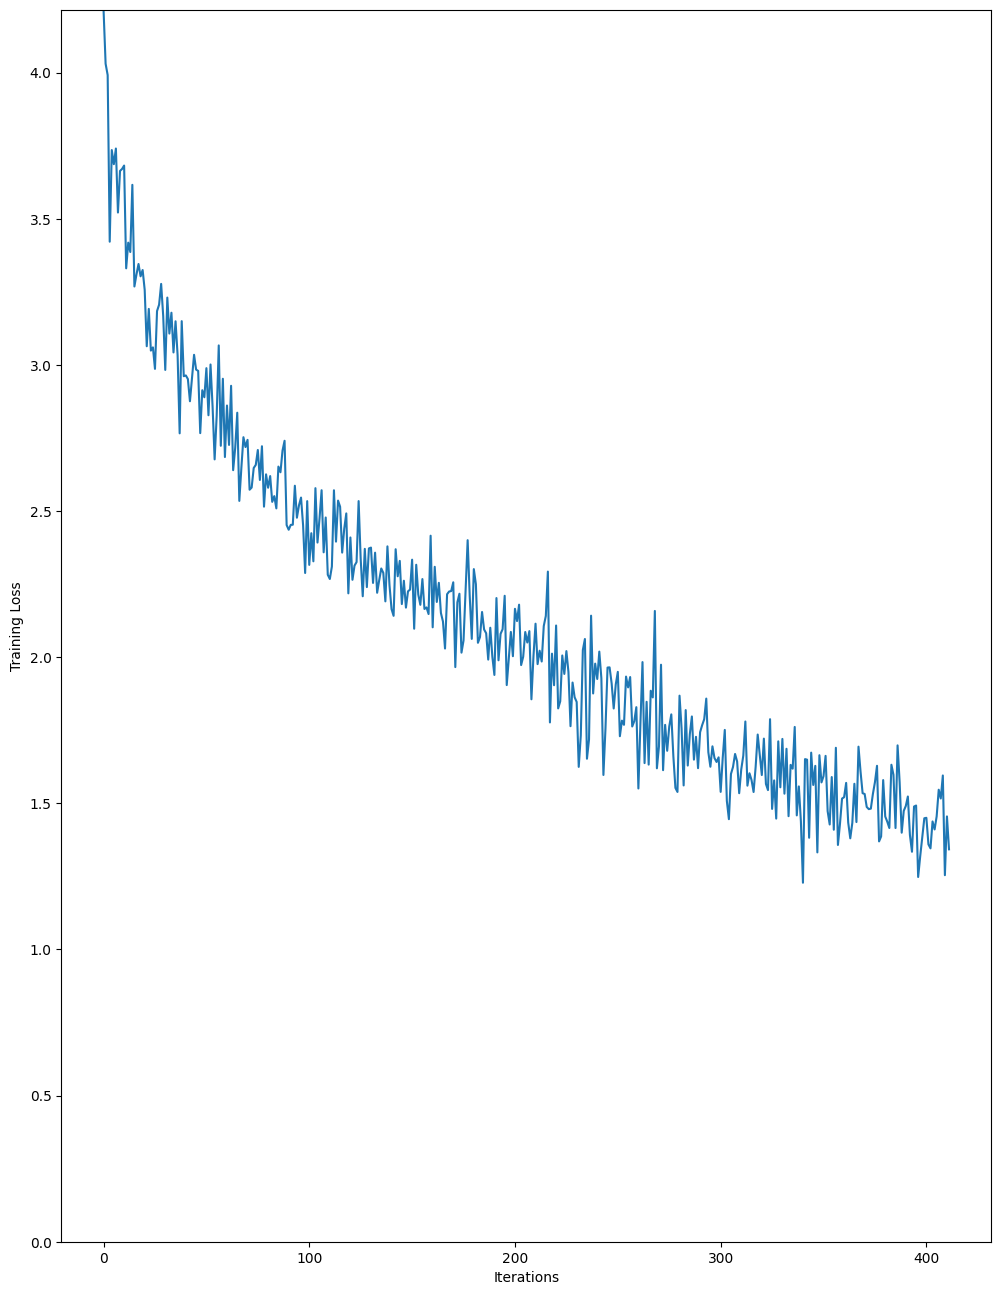

In [27]:
hidden_size = 512
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = Decoder(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 2, print_every=5000, train=train1)

evaluateRandomly(encoder1, decoder1, evaluate=evaluate1)
input,gt,predict,score = test(encoder1, decoder1, train_pairs, evaluate=evaluate1)
input,gt,predict,score = test(encoder1, decoder1, test_pairs, evaluate=evaluate1)

Epoch: 0/2
1m 11s (- 8m 38s) (5000 12%) 3.3683
2m 24s (- 7m 32s) (10000 24%) 2.9083
3m 39s (- 6m 23s) (15000 36%) 2.6791
4m 53s (- 5m 11s) (20000 48%) 2.4984
Epoch: 1/2
6m 7s (- 3m 58s) (25000 60%) 2.3123
7m 21s (- 2m 45s) (30000 72%) 2.1495
8m 36s (- 1m 31s) (35000 84%) 2.0129
9m 50s (- 0m 18s) (40000 97%) 1.9142
> je me sens un peu fatigue .
= i m feeling a little tired .
< i m feeling tired . <EOS>

> je quitte l australie .
= i m leaving australia .
< i m leaving . <EOS>

> je suis conscient des consequences .
= i m aware of the consequences .
< i m aware of the . <EOS>

> tu es imprevisible .
= you re unpredictable .
< you re talented . <EOS>

> tu es si belle dans cette robe !
= you re so beautiful in that dress .
< you re so beautiful in that dress . <EOS>

> vous n y etes pas autorise .
= you re not allowed in there .
< you re not allowed to . <EOS>

> tu es la plus belle fille du monde .
= you re the most beautiful girl in the world .
< you re the most beautiful woman woman . 

100%|██████████| 2291/2291 [00:16<00:00, 137.07it/s]


=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.57037586
Rouge1 precision:	 0.54637647
Rouge1 recall:  	 0.6052775
Rouge2 fmeasure:	 0.372787
Rouge2 precision:	 0.3522403
Rouge2 recall:  	 0.40444332


100%|██████████| 20616/20616 [02:30<00:00, 137.07it/s]


=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.60158986
Rouge1 precision:	 0.5764233
Rouge1 recall:  	 0.637757
Rouge2 fmeasure:	 0.40399328
Rouge2 precision:	 0.38184258
Rouge2 recall:  	 0.43781084


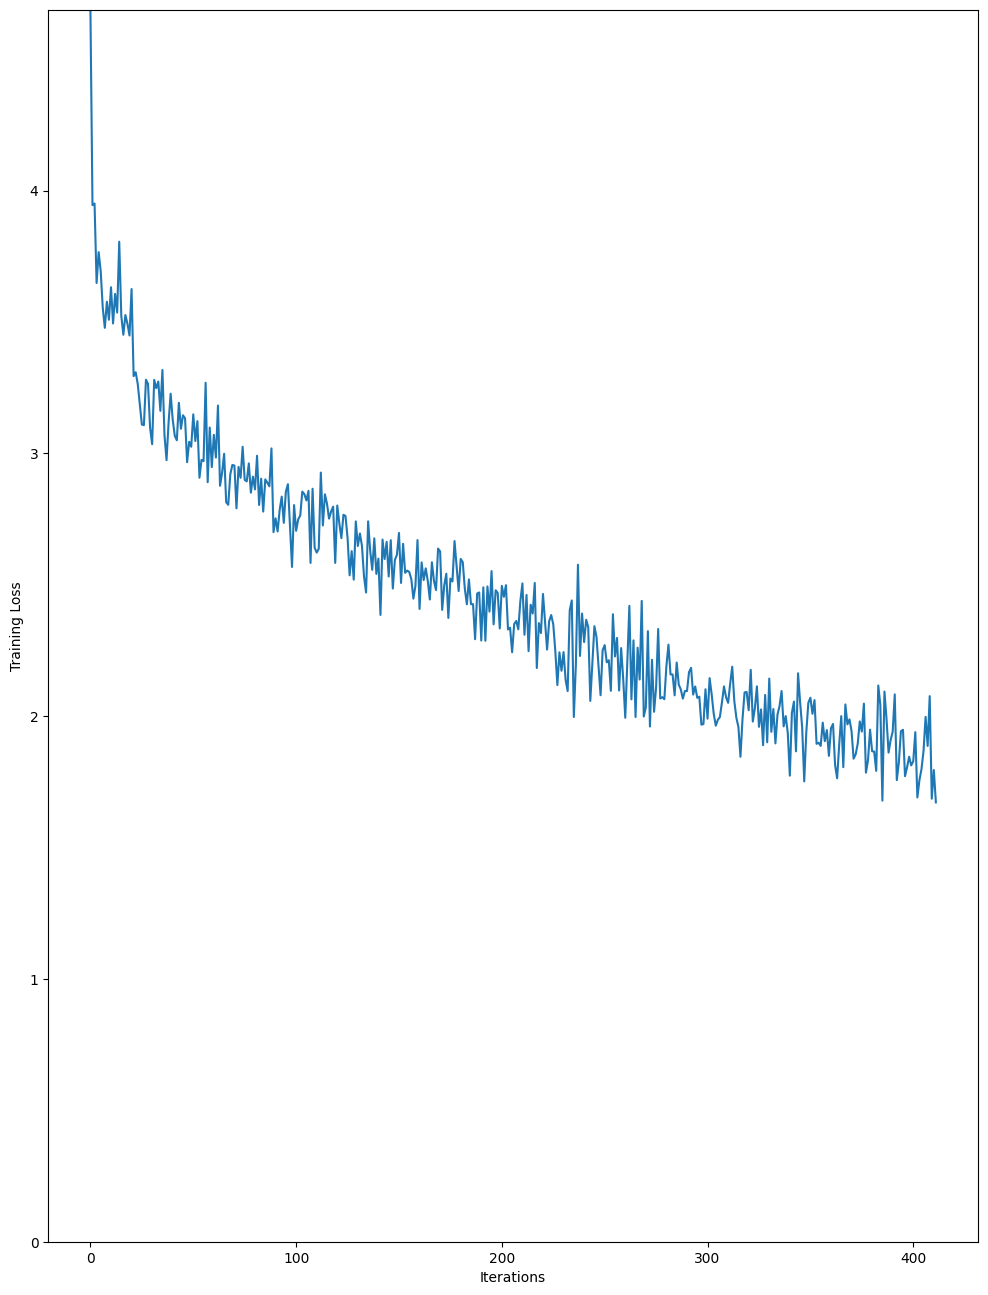

In [28]:
hidden_size = 512
encoder1 = EncoderLSTM(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderLSTM(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 2, print_every=5000, train=train2)
evaluateRandomly(encoder1, decoder1, evaluate=evaluate2)

input,gt,predict,score = test(encoder1, decoder1, test_pairs, evaluate=evaluate2)
input,gt,predict,score = test(encoder1, decoder1, train_pairs, evaluate=evaluate2)

Epoch: 0/2
1m 17s (- 9m 18s) (5000 12%) 3.4122
2m 36s (- 8m 7s) (10000 24%) 2.9042
3m 55s (- 6m 51s) (15000 36%) 2.6165
5m 15s (- 5m 34s) (20000 48%) 2.4099
Epoch: 1/2
6m 35s (- 4m 16s) (25000 60%) 2.2086
7m 55s (- 2m 57s) (30000 72%) 2.0393
9m 15s (- 1m 38s) (35000 84%) 1.8944
10m 35s (- 0m 19s) (40000 97%) 1.7865
> tu es naive .
= you re naive .
< you re naive . <EOS>

> il parle l anglais couramment .
= he speaks english fluently .
< he speaks english english . <EOS>

> nous sommes pour ainsi dire pretes .
= we re about ready .
< we re ready to this . <EOS>

> je ne suis pas un expert .
= i m no expert .
< i m not a . . <EOS>

> ils sont artistes .
= they are artists .
< they re rich . <EOS>

> je ne suis pas fier de moi .
= i m not proud of myself .
< i m not proud of myself . <EOS>

> j ai seize ans .
= i am sixteen years old .
< i m . . <EOS>

> je suis assez certain qu il ne neigera pas aujourd hui .
= i m pretty sure it won t snow today .
< i m pretty sure that won t happen tod

100%|██████████| 2291/2291 [00:17<00:00, 134.50it/s]


=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.5825699
Rouge1 precision:	 0.5560706
Rouge1 recall:  	 0.62167156
Rouge2 fmeasure:	 0.38206443
Rouge2 precision:	 0.35828125
Rouge2 recall:  	 0.41863322


100%|██████████| 20616/20616 [02:34<00:00, 133.45it/s]


=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.6203933
Rouge1 precision:	 0.5911769
Rouge1 recall:  	 0.6619157
Rouge2 fmeasure:	 0.42324743
Rouge2 precision:	 0.3964009
Rouge2 recall:  	 0.4630641


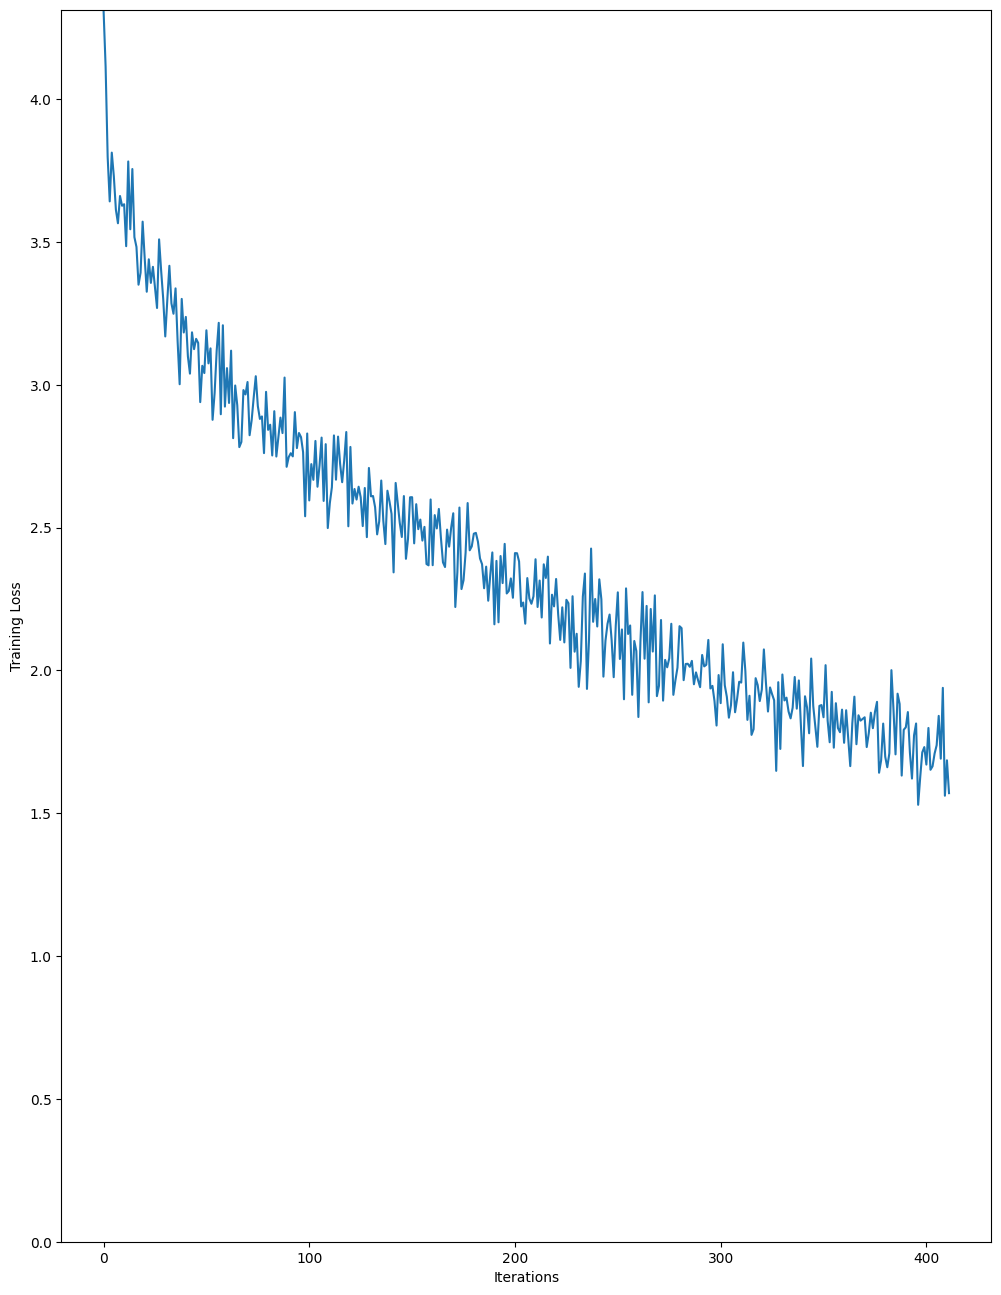

In [29]:
hidden_size = 256
encoder1 = EncoderLSTMBi(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderLSTMBi(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 2, print_every=5000, train=train3)
evaluateRandomly(encoder1, decoder1, evaluate=evaluate3)

input,gt,predict,score = test(encoder1, decoder1, test_pairs, evaluate=evaluate3)
input,gt,predict,score = test(encoder1, decoder1, train_pairs, evaluate=evaluate3)

Epoch: 0/2
1m 39s (- 11m 57s) (5000 12%) 3.2344
3m 20s (- 10m 24s) (10000 24%) 2.6507
5m 1s (- 8m 47s) (15000 36%) 2.3328
6m 44s (- 7m 9s) (20000 48%) 2.1409
Epoch: 1/2
8m 28s (- 5m 29s) (25000 60%) 1.9324
10m 11s (- 3m 48s) (30000 72%) 1.7377
11m 54s (- 2m 7s) (35000 84%) 1.5770
13m 38s (- 0m 25s) (40000 97%) 1.4802
> je suis respectueuse .
= i m observant .
< i m an . <EOS>

> il est plus que probable qu il vienne .
= he s more than likely to come .
< he is more than likely to come . <EOS>

> vous etes en securite .
= you re safe .
< you re safe . <EOS>

> tu es inefficace .
= you re inefficient .
< you re stuck . <EOS>

> nous quittons boston .
= we re leaving boston .
< we re in boston . <EOS>

> je vais a la maison maintenant .
= i m going home now .
< i m going home now now . <EOS>

> je suis ravi de te voir .
= i m pleased to see you .
< i m really glad to see you . <EOS>

> elle declara qu elle le suivrait ou qu il aille .
= she said that she would follow him no matter where he

100%|██████████| 2291/2291 [00:20<00:00, 110.88it/s]


=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.6213793
Rouge1 precision:	 0.5903027
Rouge1 recall:  	 0.6661675
Rouge2 fmeasure:	 0.4284501
Rouge2 precision:	 0.3993881
Rouge2 recall:  	 0.47188753


100%|██████████| 20616/20616 [03:06<00:00, 110.63it/s]


=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.68806785
Rouge1 precision:	 0.65075564
Rouge1 recall:  	 0.7393444
Rouge2 fmeasure:	 0.51409614
Rouge2 precision:	 0.47719076
Rouge2 recall:  	 0.5673634


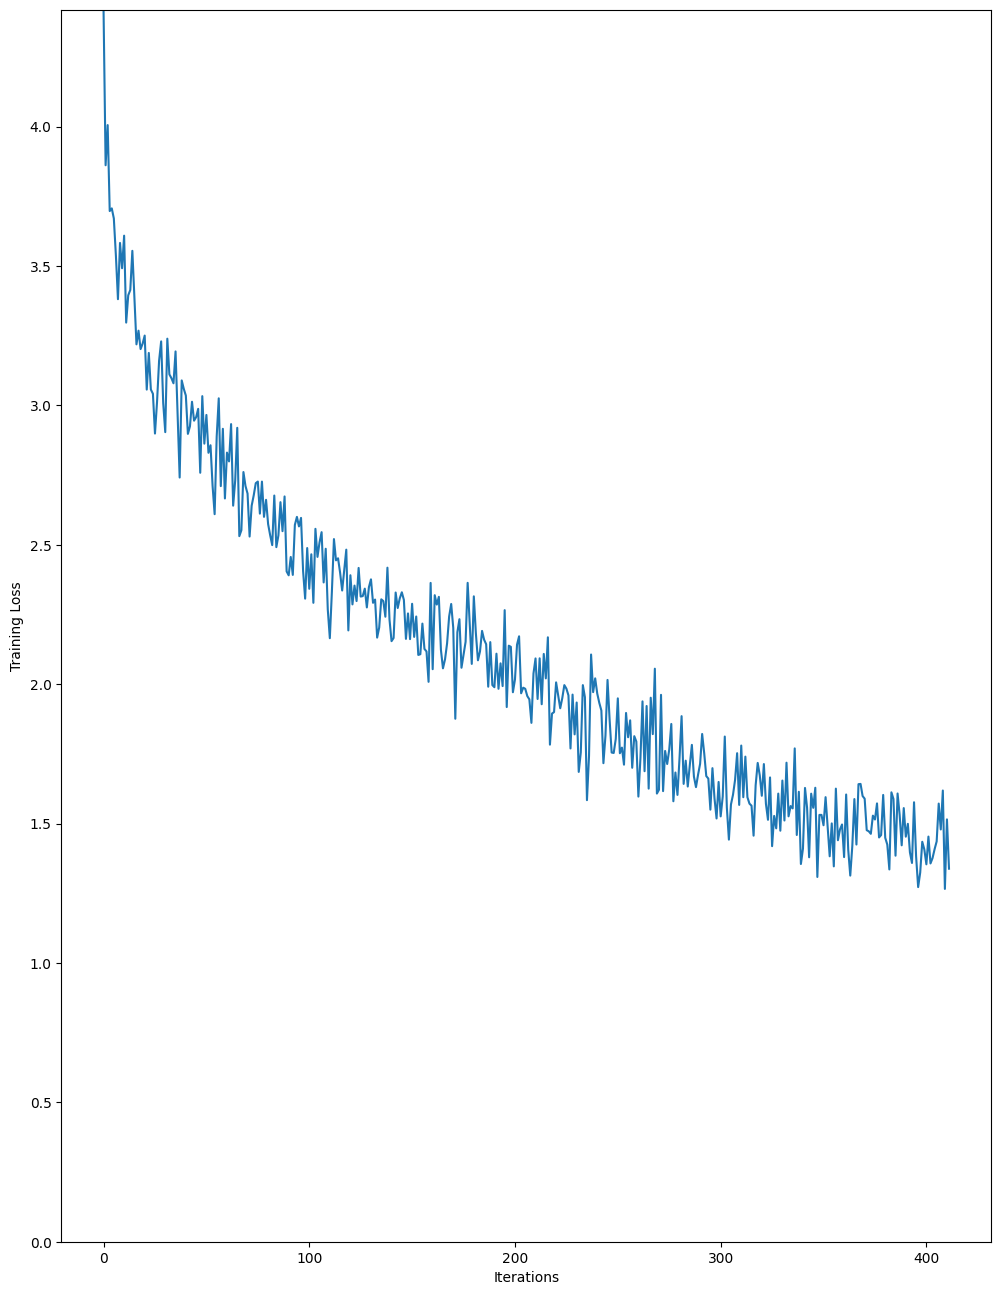

In [32]:
def evaluateRandomly(encoder, decoder, evaluate, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        # output_words = evaluate(encoder, decoder, pair[0])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

from torchmetrics.text.rouge import ROUGEScore
from tqdm import tqdm
import numpy as np

rouge = ROUGEScore()

def test(encoder, decoder, testing_pairs, evaluate):
    input = []
    gt = []
    predict = []
    metric_score = {
        "rouge1_fmeasure":[],
        "rouge1_precision":[],
        "rouge1_recall":[],
        "rouge2_fmeasure":[],
        "rouge2_precision":[],
        "rouge2_recall":[]
    }
    from tqdm import tqdm
    for i in tqdm(range(len(testing_pairs))):
        pair = testing_pairs[i]
        # output_words = evaluate(encoder, decoder, pair[0])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)

        input.append(pair[0])
        gt.append(pair[1])
        predict.append(output_sentence)

        try:
            rs = rouge(output_sentence, pair[1])
        except:
            continue
        metric_score["rouge1_fmeasure"].append(rs['rouge1_fmeasure'])
        metric_score["rouge1_precision"].append(rs['rouge1_precision'])
        metric_score["rouge1_recall"].append(rs['rouge1_recall'])
        metric_score["rouge2_fmeasure"].append(rs['rouge2_fmeasure'])
        metric_score["rouge2_precision"].append(rs['rouge2_precision'])
        metric_score["rouge2_recall"].append(rs['rouge2_recall'])

    metric_score["rouge1_fmeasure"] = np.array(metric_score["rouge1_fmeasure"]).mean()
    metric_score["rouge1_precision"] = np.array(metric_score["rouge1_precision"]).mean()
    metric_score["rouge1_recall"] = np.array(metric_score["rouge1_recall"]).mean()
    metric_score["rouge2_fmeasure"] = np.array(metric_score["rouge2_fmeasure"]).mean()
    metric_score["rouge2_precision"] = np.array(metric_score["rouge2_precision"]).mean()
    metric_score["rouge2_recall"] = np.array(metric_score["rouge2_recall"]).mean()

    print("=== Evaluation score - Rouge score ===")
    print("Rouge1 fmeasure:\t",metric_score["rouge1_fmeasure"])
    print("Rouge1 precision:\t",metric_score["rouge1_precision"])
    print("Rouge1 recall:  \t",metric_score["rouge1_recall"])
    print("Rouge2 fmeasure:\t",metric_score["rouge2_fmeasure"])
    print("Rouge2 precision:\t",metric_score["rouge2_precision"])
    print("Rouge2 recall:  \t",metric_score["rouge2_recall"])
    print("=====================================")
    return input,gt,predict,metric_score


hidden_size = 512
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderAttn(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 2, print_every=5000, train=train4)
evaluateRandomly(encoder1, decoder1, evaluate=evaluate4) # cannot find positional argument cell?

input,gt,predict,score = test(encoder1, decoder1, test_pairs, evaluate=evaluate4)
input,gt,predict,score = test(encoder1, decoder1, train_pairs, evaluate=evaluate4)

transformer model

In [ ]:
# class PositionalEncoding(nn.Module):
#     """
#     Implements positional encoding as described in the Transformer model.
#     """
#     def __init__(self, input_size: int, dropout: float = 0.1, max_len: int = MAX_LENGTH):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         position = torch.arange(max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, input_size, 2) * (-math.log(10000.0) / input_size))
#         pe = torch.zeros(max_len, 1, input_size)
#         pe[:, 0, 0::2] = torch.sin(position * div_term)
#         pe[:, 0, 1::2] = torch.cos(position * div_term)
#         self.register_buffer('pe', pe)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = x + self.pe[:x.size(0)]
#         return self.dropout(x)

# class TransformerModel(nn.Module):
#     """
#     Defines a Transformer model by assembling the Encoder, PositionalEncoding, and a Decoder.
#     """
#     def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int, nlayers: int, dropout: float = 0.5):
#         super(TransformerModel, self).__init__()
#         self.model_type = 'Transformer'
#         self.pos_encoder = PositionalEncoding(d_model, dropout)
#         encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
#         self.encoder = nn.Embedding(ntoken, d_model)
#         self.d_model = d_model
#         self.decoder = nn.Linear(d_model, ntoken)
#         self.init_weights()

#     def init_weights(self) -> None:
#         initrange = 0.1
#         self.encoder.weight.data.uniform_(-initrange, initrange)
#         self.decoder.bias.data.zero_()
#         self.decoder.weight.data.uniform_(-initrange, initrange)

#     def forward(self, src: torch.Tensor, src_mask: torch.Tensor) -> torch.Tensor:
#         src = self.encoder(src) * math.sqrt(self.d_model)
#         src = self.pos_encoder(src)
#         output = self.transformer_encoder(src, src_mask)
#         output = self.decoder(output)
#         return output

# def generate_square_subsequent_mask(sz: int) -> torch.Tensor:
#     """Generates an upper-triangular matrix of -inf, with zeros on diag."""
#     return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

# class EncoderRNN2(nn.Module):
#     """
#     An encoder model based on the GRU mechanism.
#     """
#     def __init__(self, hidden_size: int, output_size: int):
#         super(EncoderRNN2, self).__init__()
#         self.hidden_size = hidden_size
#         self.embedding = nn.Embedding(output_size, hidden_size)
#         self.gru = nn.GRU(hidden_size, hidden_size)
#         self.out = nn.Linear(hidden_size, output_size)
#         self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, input: torch.Tensor, hidden: torch.Tensor) -> torch.Tensor:
#         output = self.embedding(input).view(1, 1, -1)
#         output = F.relu(output)
#         output, hidden = self.gru(output, hidden)
#         output = self.softmax(self.out(output[0]))
#         return output, hidden

#     def initHidden(self) -> torch.Tensor:
#         return torch.zeros(1, 1, self.hidden_size)

In [ ]:
# teacher_forcing_ratio = 0.5

# def train5(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
#     encoder_hidden = encoder.initHidden()

#     encoder_optimizer.zero_grad()
#     decoder_optimizer.zero_grad()

#     input_length = input_tensor.size(0)
#     target_length = target_tensor.size(0)

#     encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

#     loss = 0

#     for ei in range(input_length):
#         encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
#         encoder_outputs[ei] = encoder_output[0, 0]

#     decoder_input = torch.tensor([[SOS_token]], device=device)

#     decoder_hidden = encoder_hidden

#     use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

#     if use_teacher_forcing:
#         # Teacher forcing: Feed the target as the next input
#         for di in range(target_length):
#             decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden) ##### Original ##### Task 2 & 6

#             loss += criterion(decoder_output, target_tensor[di])
#             decoder_input = target_tensor[di]  # Teacher forcing
#     else:
#         # Without teacher forcing: use its own predictions as the next input
#         for di in range(target_length):
#             decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden) ##### Original ##### Task 2 & 6

#             topv, topi = decoder_output.topk(1)
#             decoder_input = topi.squeeze().detach()  # detach from history as input

#             loss += criterion(decoder_output, target_tensor[di])
#             if decoder_input.item() == EOS_token:
#                 break


In [ ]:

# def evaluate5(encoder, decoder, sentence, max_length=MAX_LENGTH):
#     with torch.no_grad():
#         input_tensor = tensorFromSentence(input_lang, sentence)
#         input_length = input_tensor.size()[0]
#         encoder_hidden = encoder.initHidden()


#         encoder_hiddens = torch.zeros(max_length, encoder.hidden_size, device=device)

#         for ei in range(input_length):
#             encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
#             encoder_hiddens[ei] = encoder_hidden[0, 0]

#         decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

#         decoder_hidden = encoder_hidden

#         decoded_words = []
#         decoder_attentions = torch.zeros(max_length, max_length)

#         for di in range(max_length):
#             decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_hiddens)

#             decoder_attentions[di] = decoder_attention.data
#             topv, topi = decoder_output.data.topk(1)
#             if topi.item() == EOS_token:
#                 decoded_words.append('<EOS>')
#                 break
#             else:
#                 decoded_words.append(output_lang.index2word[topi.item()])

#             decoder_input = topi.squeeze().detach()

#         # return decoded_words

#         return decoded_words, decoder_attentions[:di + 1]

In [ ]:
# hidden_size = 512
# encoder1 = EncoderRNN2(input_lang.n_words, hidden_size).to(device)
# decoder1 = TransformerModel(hidden_size, output_lang.n_words, nhead=1, d_hid=1, nlayers=1).to(device)

# trainIters(encoder1, decoder1, 2, print_every=5000, train=train5)
# evaluateRandomly(encoder1, decoder1, evaluate=evaluate5) # cannot find positional argument cell?

# input,gt,predict,score = test(encoder1, decoder1, test_pairs, evaluate=evaluate5)
# input,gt,predict,score = test(encoder1, decoder1, train_pairs, evaluate=evaluate5)